In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

from datetime import datetime


import shutil
import pandas as pd

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [197]:
from skimage import exposure, img_as_float, color, io

# equalize_hist will equalise on the flatten image, hence, we should convert to grayscale first 
def AHE(img):
    img = color.rgb2gray(img)
    img = img / 255. 
#     img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    img_adapteq = exposure.equalize_hist(img)
    img_adapteq = img_adapteq * 255.
    return color.gray2rgb(img_adapteq).astype('uint8')


In [198]:
dir_str = "./nus-cs5242/"
shutil.rmtree(dir_str + "train_image/class", ignore_errors=True)
os.mkdir(dir_str + "train_image/class")
os.mkdir(dir_str + "train_image/class/0")
os.mkdir(dir_str + "train_image/class/1")
os.mkdir(dir_str + "train_image/class/2")

label = pd.read_csv(dir_str + "train_label.csv")
label_tupple = list(label.itertuples(index=False, name=None))



for i in range(len(label_tupple)):
    img_ext = str(label_tupple[i][0])
    img_class = str(label_tupple[i][1])
    
    img = io.imread(dir_str + "train_image/train_image/"+img_ext+".png")
    img = AHE(img)
    io.imsave(dir_str + "train_image/class/"+img_class+"/"+img_ext+".png", img)

data_dir=dir_str + "train_image/class"
data_dir = pathlib.Path(data_dir)
print(data_dir)

nus-cs5242/train_image/class


In [278]:
# create tf datasets and load data, note: didn't use graysacle as all pretrained models over imagenet are RGB 
batch_size = 16
img_height = 512
img_width = 512
num_classes = 3

from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_gen = ImageDataGenerator(horizontal_flip=True,
                              vertical_flip=False,
#                               samplewise_std_normalization=True,
                              zca_whitening=False,
                              rotation_range=20,
                              zoom_range=0.2,
#                               brightness_range=
                              validation_split=0.2,
                              fill_mode='wrap',
#                               preprocessing_function = AHE
                              ) 

train_gen = data_gen.flow_from_directory(data_dir, 
                                         target_size=(img_width,img_height),
#                                          color_mode='grayscale',
                                         class_mode='categorical',
                                         batch_size=batch_size, 
                                         subset='training',
                                         shuffle=True)
val_gen = data_gen.flow_from_directory(data_dir, 
                                        target_size=(img_width, img_height),
#                                         color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=batch_size, 
                                        subset='validation',
                                        shuffle=True)
class_names = list(train_gen.class_indices.values())
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   #labels=train_labels,
#   #label_mode='int',
#   #color_mode='grayscale',
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

# class_names = train_ds.class_names


Found 933 images belonging to 3 classes.
Found 231 images belonging to 3 classes.


In [279]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   #labels=train_labels,
#   #color_mode='grayscale',
#   #label_mode='int',
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

<Figure size 1440x1440 with 0 Axes>

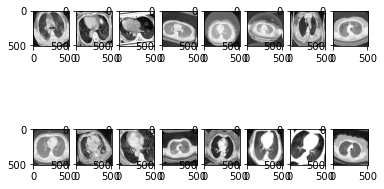

In [280]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
img, label = next(train_gen)

fig, axs = plt.subplots(batch_size//8, 8)

for i in range(batch_size):
    axs[i//8][i%8].imshow(img[i].astype("uint8"))


# for images, labels in train_ds.take(1):
#     for i in range(3):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         #plt.title(class_names[labels[i]])
#         plt.axis("off")

### Test transfer learning model ResNet50

In [281]:
# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=(512,512,3),
#                                               include_top=False,
#                                               weights='imagenet')


from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

base_model = ResNet50(input_shape=(512,512,3),
                                               include_top=False,
                                               weights='imagenet')


In [282]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [283]:
# image_batch, label_batch = next(iter(train_ds))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [284]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 165

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
for i, layer in enumerate(base_model.layers):
    print(i,layer.name,"-",layer.trainable)

Number of layers in the base model:  175
0 input_27 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block

In [285]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_27[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [286]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [287]:
# prediction_layer = tf.keras.layers.Dense(3)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [296]:
data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.Normalization(),
#   tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

In [301]:
# construct model 

# preprocess_input = tf.keras.applications.resnet50.preprocess_input

inputs = tf.keras.Input(shape=(512, 512, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)


x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)


x = tf.keras.layers.Dense(3, activation='softmax')(x)
# outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)


In [302]:
# base_learning_rate = 0.001
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])
# step = tf.Variable(0, trainable=False)

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    [300, 600, 1000], [ 0.001, 0.0001, 0.00001, 0.000001])


model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.03, from_logits=True ),
              metrics=['accuracy'])


In [303]:
model.summary()


Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_20 [(None, 512, 512, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_20 (Tens [(None, 512, 512, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_19  (None, 2048)              0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)             

In [305]:
epochs=25
history = model.fit(
  train_gen,
  validation_data=val_gen,
  epochs=epochs,
  workers=8
)
# history = model.fit_generator(
#     train_gen,
#     validation_data=val_gen,
#     epochs=epochs
# )

Epoch 1/25
59/59 [==============================] - 18s 306ms/step - loss: 0.8546 - accuracy: 0.7085 - val_loss: 0.6535 - val_accuracy: 0.9264
Epoch 2/25
59/59 [==============================] - 17s 290ms/step - loss: 0.7191 - accuracy: 0.8607 - val_loss: 0.6400 - val_accuracy: 0.9307
Epoch 3/25
59/59 [==============================] - 17s 295ms/step - loss: 0.7048 - accuracy: 0.8725 - val_loss: 0.6241 - val_accuracy: 0.9524
Epoch 4/25
59/59 [==============================] - 18s 297ms/step - loss: 0.6851 - accuracy: 0.8907 - val_loss: 0.6299 - val_accuracy: 0.9394
Epoch 5/25
59/59 [==============================] - 17s 293ms/step - loss: 0.6735 - accuracy: 0.9046 - val_loss: 0.6202 - val_accuracy: 0.9524
Epoch 6/25
59/59 [==============================] - 17s 293ms/step - loss: 0.6485 - accuracy: 0.9303 - val_loss: 0.6102 - val_accuracy: 0.9654
Epoch 7/25
59/59 [==============================] - 18s 298ms/step - loss: 0.6417 - accuracy: 0.9357 - val_loss: 0.6110 - val_accuracy: 0.9610

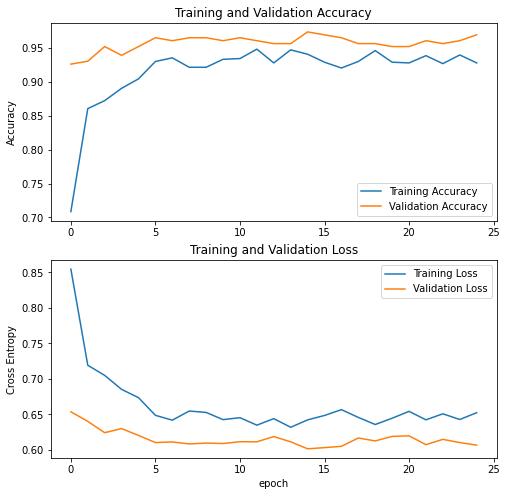

In [306]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [307]:
import os

output = []
    
test_folder = dir_str + "test_image/test_image"

for file in os.listdir(test_folder):
    filename = str(file).replace(".png","")
    image_path = os.path.join(test_folder, file)
    #print(filename, image_path)
    
#     img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
#     img_array = keras.preprocessing.image.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0) # Create a batch
#     print(img_array.shape)
    img = io.imread(image_path)
    img = AHE(img)
    img = img[ np.newaxis, :]

    predictions = model.predict(img)

    score = predictions[0]
    label = class_names[np.argmax(score)]
#     label = class_names[np.argmax(score)]

    output.append([filename, label])
    #print(
    #    "This image most likely belongs to {} with a {:.2f} percent confidence."
    #    .format(class_names[np.argmax(score)], 100 * np.max(score))
    #)
    

In [308]:
results = pd.DataFrame(output, columns = ['ID' , 'Label']) 
results.ID = results.ID.astype(int)
results = results.sort_values(by="ID")

In [309]:
results.to_csv(dir_str + "submission_resnet50_" + datetime.today().strftime('%Y-%m-%d-%H-%M-%S') + ".csv", index=False)

## Spot wrong images

In [250]:
i = 1

for img, label in next(val_gen).items(): #val_ds, train_ds

    pred = np.argmax(model.predict(img), axis=1)
#     print(pred)
#     print(label.numpy())

    
    wrong_idx = np.where(pred != label.numpy())[0]
    print(wrong_idx)
    
    if len(wrong_idx) < 1:
        continue
    
    plt.figure(i)
    f, axarr = plt.subplots(len(wrong_idx))
    
    if len(wrong_idx) == 1:
        plt.imshow(img[wrong_idx[0]].numpy().astype('uint8'))
    else:
        for j in range(len(wrong_idx)):
#             print(j)
            axarr[j].imshow(img[wrong_idx[j]].numpy().astype('uint8'))
    plt.show()
    i = i + 1

AttributeError: 'tuple' object has no attribute 'items'